This notebook generates pixelwise masks for each of the classes. The class information is provided in polygon form in `train_wkt_v4.csv` and is scaled according to the image sizes `60##_#_#_{}.tiff` and grid sizes in `grid_sizes.csv`.  It produces both a `.npz` containing a dict of masks for each image and a `.hdf5` containing all image data stacked into a large 4D-tensor. The `.hdf5` format is chosen as the size of the tensor exceeds the maximum allowed by the `.npz` format, due to its use of `zip` that has a cap at 12 GB.

First import the necessary modules and set the global variables N_CLASSES, BAND and MASK_SIZES.

In [27]:
import os
import csv
import sys
import cv2
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff
from matplotlib import pyplot as plt
%matplotlib inline
import itertools
csv.field_size_limit(sys.maxsize)
import h5py

import helper # this module contains some function that are used by a few of the notebooks on this matter

N_CLASSES = 10
BAND = 'RGB' # which band to use
MASK_SIZES = {'A': 128, 'M': 800, 'P': 3*1024, 'RGB': 3*1024} # size of the Mask ARRAY to use
DEPTHS = {'A': 8, 'M': 8, 'P': 1, 'RGB': 3}
data_dir = '/data/dstl'
if BAND == 'RGB':
    dir_name = os.path.join(data_dir, 'three_band')
else:
    dir_name =  os.path.join(data_dir, 'sixteen_band')

Now define and run a function that fetches the size of each image and the scaler (x and y dir) required for scaling the polygons to the correct shape.

In [28]:
def create_sizes_and_scalers():
    im_sizes = {}
    scalers = {}
    
    for im_id in helper.image_iterator():
        masks_per_im = []
        im = tiff.imread(os.path.join(dir_name, 'TIFFImages', '{}_{}.tiff'.format(im_id, BAND)))
        im_size = im.shape[-2::] # last two, regardless of whether there are three dims or not
        im_sizes[im_id] = im_size

    with open(os.path.join(data_dir, 'grid_sizes.csv')) as inf:
        reader = csv.reader(inf)
        next(reader)
        for im_id, x, y in reader:
            print im_id
            scaler = np.array(im_sizes[im_id])
            scaler = scaler * scaler.astype(float) / (scaler + 1)
            scalers[im_id] = (scaler[1]/float(x), scaler[0]/float(y))
    return im_sizes, scalers

im_sizes, scalers = create_sizes_and_scalers()

6120_2_4
6120_2_3
6120_2_2
6120_2_1
6120_2_0
6180_2_4
6180_2_1
6180_2_0
6180_2_3
6180_2_2
6180_0_3
6180_0_2
6180_0_1
6180_0_0
6180_0_4
6080_4_4
6080_4_2
6080_4_3
6080_4_0
6080_4_1
6090_4_1
6090_4_0
6090_4_3
6090_4_2
6090_4_4
6180_4_4
6180_4_3
6180_4_2
6180_4_1
6180_4_0
6160_3_2
6160_3_3
6160_3_0
6160_3_1
6160_3_4
6080_2_4
6080_2_0
6080_2_1
6080_2_2
6080_2_3
6080_0_2
6080_0_3
6080_0_0
6080_0_1
6080_0_4
6010_0_4
6010_0_1
6010_0_0
6010_0_3
6010_0_2
6010_2_3
6010_2_2
6010_2_1
6010_2_0
6010_2_4
6010_4_1
6170_3_4
6010_4_3
6010_4_2
6170_3_1
6170_3_0
6170_3_3
6170_3_2
6170_1_3
6170_1_2
6170_1_1
6170_1_0
6170_1_4
6130_4_2
6130_4_3
6130_4_0
6130_4_1
6130_4_4
6150_3_3
6150_3_2
6150_3_1
6150_3_0
6150_3_4
6130_2_0
6130_2_1
6130_2_2
6130_2_3
6130_2_4
6130_0_4
6130_0_2
6130_0_3
6130_0_0
6130_0_1
6150_1_4
6150_1_1
6150_1_0
6150_1_3
6150_1_2
6180_3_4
6180_3_0
6180_3_1
6180_3_2
6180_3_3
6180_1_2
6180_1_3
6180_1_0
6180_1_1
6180_1_4
6010_1_4
6010_1_0
6010_1_1
6010_1_2
6010_1_3
6010_3_2
6010_3_3
6010_3_0
6

Fill the masks with binary pixels indicating whether the pixel is in a certain class or not. We only create a dict entry for images that contain any class data. 

In [29]:
def fill_masks(im_sizes, scalers):
    masks = {}
    polygons = {}

    with open(os.path.join(data_dir, 'train_wkt_v4.csv')) as inf:
        train = csv.reader(inf)
        next(train) # skip the header row
        for row_i, (im_id, poly_type, wktpoly) in enumerate(train):
            poly_type = int(poly_type) - 1
            int_coords = lambda x: np.array(x).round().astype(np.int32)
            polygons = shapely.wkt.loads(wktpoly)
            x_scaler, y_scaler = scalers[im_id]
            polygons = shapely.affinity.scale(polygons, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))

            if polygons:
                exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
                interiors = [int_coords(pi.coords) for poly in polygons
                             for pi in poly.interiors]

                # create masks for this image if they do not yet exist
                if not im_id in masks:
                    masks[im_id] = {}
                    for c in range(N_CLASSES):
                        masks[im_id][c] = np.zeros(im_sizes[im_id], dtype=np.uint8)

                im_mask = masks[im_id][poly_type]
                cv2.fillPoly(im_mask, exteriors, 1)
                cv2.fillPoly(im_mask, interiors, 0)
                masks[im_id][poly_type] = im_mask
                # some output to keep track of the progress
                print im_id, poly_type, masks[im_id][poly_type].sum(), len(polygons)
        print row_i
    return masks

masks = fill_masks(im_sizes, scalers)

6040_2_2 3 115452 2
6040_2_2 4 2277428 3879
6120_2_2 0 2507879 1962
6120_2_2 1 359153 3201
6120_2_2 2 494913 1
6120_2_2 3 991688 33
6120_2_2 4 549677 1452
6120_2_2 5 1182526 20
6120_2_2 7 33466 6
6120_2_2 8 1066 9
6120_2_2 9 23919 548
6120_2_0 0 227162 573
6120_2_0 1 122756 1193
6120_2_0 2 100147 1
6120_2_0 3 509898 4
6120_2_0 4 692112 1542
6120_2_0 5 9114404 67
6120_2_0 8 1756 6
6120_2_0 9 601 11
6090_2_0 1 4269 11
6090_2_0 3 52366 3
6090_2_0 4 1232872 2308
6090_2_0 5 3218031 7
6090_2_0 7 37986 19
6090_2_0 9 113 1
6040_1_3 3 24440 1
6040_1_3 4 2288664 3982
6040_1_3 5 417948 2
6040_1_0 3 173517 5
6040_1_0 4 986867 2446
6100_1_3 0 1080244 2208
6100_1_3 1 392603 1581
6100_1_3 2 257922 1
6100_1_3 3 1386886 13
6100_1_3 4 744498 823
6100_1_3 5 307262 3
6100_1_3 7 78731 4
6100_1_3 8 1501 11
6100_1_3 9 6591 129
6010_4_2 3 235716 6
6010_4_2 4 1494845 2262
6110_4_0 0 295855 437
6110_4_0 1 89303 502
6110_4_0 2 213667 2
6110_4_0 3 332377 11
6110_4_0 4 700124 1406
6110_4_0 5 9205384 29
6110_4_0 7 

Save the result to masks_{}.npz

In [30]:
np.savez(os.path.join(data_dir, 'masks_{}.npz'.format(BAND)), masks=masks, im_sizes=im_sizes)

Load the data from the drive (only if not already in memory)

In [87]:
masks = np.load(os.path.join(data_dir, 'masks_{}.npz'.format(BAND)))['masks'][()]

We now construct an array of size N_MASKS x MASK_SIZE x MASK_SIZE x depth

In [31]:
mask_size = MASK_SIZES[BAND]
N_tot = len(masks)
N_val = 5
N_trn = N_tot - N_val
print N_tot, N_trn, N_val

X_tot = np.zeros((N_tot, mask_size, mask_size, DEPTHS[BAND]), dtype=int)
y_tot = np.zeros((N_tot, mask_size, mask_size, N_CLASSES), dtype=int)
id_val = [] # we will also keep track of which im_id's belong to training and validation sets
id_trn = []

25 20 5


Now we make a choice which of the array's elements will be in the validation set, the rest will be used for training

In [32]:
np.random.seed(21)
choice = np.sort(np.random.choice(range(N_tot), N_val, replace=False))
# sort not required, but the results WILL be sorted by using bool mask instead of vector indexing
print 'The validation will contain the following items:', choice

The validation will contain the following items: [ 1  5  7 13 18]


Loop over all images, but tell iterator to only produce ids that have masks.
Note that this could also be done via a loop over the masks, but we previously also included empty data, and might wish to so again in the future

In [33]:
for i, im_id in enumerate(helper.image_iterator(masks.keys())):
    im = tiff.imread(os.path.join(dir_name, 'TIFFImages', '{}_{}.tiff'.format(im_id, BAND)))
    if im.ndim == 2:
        im = im[np.newaxis, ...] # turn single band arrays into 1 x M X N (later M x N x 1)
    im = im.transpose([1, 2, 0])
    x = np.random.randint(im.shape[0] - mask_size)
    y = np.random.randint(im.shape[1] - mask_size)
    X_tot[i, ...] = im[x:x + mask_size, y:y + mask_size, :]
    tmp_sum = int(0)
    for c in range(N_CLASSES):
        y_tot[i, ..., c] = masks[im_id][c][x:x + mask_size, y:y + mask_size]
        tmp_sum += masks[im_id][c].sum(dtype=int)
        print im_id, c, y_tot[i, c, ...].sum()
    if i in choice:
        id_val.append(im_id)
    else:
        id_trn.append(im_id)

6010_1_2 0 0
6010_1_2 1 0
6010_1_2 2 0
6010_1_2 3 43
6010_1_2 4 195
6010_1_2 5 187
6010_1_2 6 183
6010_1_2 7 175
6010_1_2 8 179
6010_1_2 9 197
6010_4_2 0 0
6010_4_2 1 0
6010_4_2 2 0
6010_4_2 3 107
6010_4_2 4 521
6010_4_2 5 507
6010_4_2 6 510
6010_4_2 7 509
6010_4_2 8 507
6010_4_2 9 508
6010_4_4 0 0
6010_4_4 1 0
6010_4_4 2 0
6010_4_4 3 0
6010_4_4 4 716
6010_4_4 5 732
6010_4_4 6 730
6010_4_4 7 708
6010_4_4 8 711
6010_4_4 9 688
6040_1_0 0 0
6040_1_0 1 0
6040_1_0 2 0
6040_1_0 3 100
6040_1_0 4 391
6040_1_0 5 386
6040_1_0 6 376
6040_1_0 7 376
6040_1_0 8 371
6040_1_0 9 359
6040_1_3 0 0
6040_1_3 1 0
6040_1_3 2 0
6040_1_3 3 20
6040_1_3 4 343
6040_1_3 5 338
6040_1_3 6 333
6040_1_3 7 333
6040_1_3 8 317
6040_1_3 9 333
6040_2_2 0 0
6040_2_2 1 0
6040_2_2 2 0
6040_2_2 3 44
6040_2_2 4 1027
6040_2_2 5 1028
6040_2_2 6 1048
6040_2_2 7 1066
6040_2_2 8 1095
6040_2_2 9 1111
6040_4_4 0 0
6040_4_4 1 0
6040_4_4 2 0
6040_4_4 3 111
6040_4_4 4 154
6040_4_4 5 149
6040_4_4 6 153
6040_4_4 7 160
6040_4_4 8 158
6040_4

In [77]:
del(masks) # save memory

We could perform some modification on the images (in bulk) to normalize the data. However, the information is currently rather compact due to its form of an unsigned integer, this is probably best kept this way.

Splitting the array into a validation and a training part

In [34]:
mask = np.zeros((N_tot,), dtype=bool)
mask[choice] = True
X_val = X_tot[mask]
y_val = y_tot[mask]
mask = np.ones((N_tot,), dtype=bool)
mask[choice] = False
X_trn = X_tot[mask]
y_trn = y_tot[mask]
print y_val.shape, y_val.sum()
print y_trn.shape, y_trn.sum()

(5, 3072, 3072, 10) 27763498
(20, 3072, 3072, 10) 84801861


Saving the arrays into a single hdf5 file, including which id's belong to training and validation. Note that the file size for the `RGB` images is too large for npz, therefor we opt for the hdf5 format.

In [ ]:
with h5py.File(os.path.join(data_dir, 'trn_val_{}.hdf5'.format(BAND)), 'w') as trn_val_file:
    trn_val_file['X_trn']=X_trn
    trn_val_file['y_trn']=y_trn
    trn_val_file['X_val']=X_val
    trn_val_file['y_val']=y_val
    trn_val_file['id_trn']=id_trn
    trn_val_file['id_val']=id_val
    trn_val_file['choice']=choice

With all the work done, let us inspect some of the results

In [111]:
print y_val.sum(axis=(1, 2)) # to look at interesting classes in the validation set
print y_trn.sum(axis=(1, 2)) # to look at interesting classes in the training set
print 'class totals:\n', y_tot.sum(axis=(0, 1, 2))
print 'class frequencies:\n', y_tot.sum(axis=(0, 1, 2))/float(y_tot.size)
print 'validation ids:\n', id_val

[[     0      0      0  19733 160843      0      0      0      0      0]
 [     0      0      0      0 227147      0      0      0      0      0]
 [   723   3870      0  20709  92632 907660      0      0      0      0]
 [ 11708  25272      0  56862  28957 936662      0   1453      0     34]
 [314079  37749      0  52282  22868 124332      0   3323      0     98]]
[[      0    1153       0   12900   36462       0       0       0       0
        0]
 [      0       0       0       0  145997       0       0       0       0
        0]
 [      0       0       0   29897   95777       0       0       0       0
        0]
 [      0       0       0       0  239700    7051       0       0       0
        0]
 [      0       0       0    3440   50499       0       0       0       0
        0]
 [      0       0       0       0  494708       0  210548       0       0
        0]
 [      0       0       0    7798  249756  178615       0    9183       0
        0]
 [ 213775   49869   24069  163871  1002

(<matplotlib.figure.Figure at 0x7f4071685e90>,
 <matplotlib.image.AxesImage at 0x7f4032b762d0>)

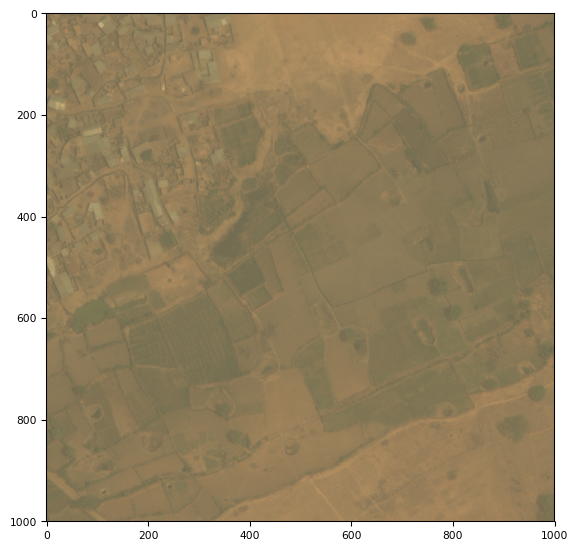

In [14]:
i_val = 4
im_id = id_val[i_val] # Let's look at the first image in the validation set
im = tiff.imread(os.path.join(dir_name, 'TIFFImages', '{}_{}.tiff'.format(im_id, BAND)))
tiff.imshow(im[:, 1000:2000, 2000:3000], interpolation='none')


In [15]:
def show(img, interpolation='none', **kwargs):
    plt.imshow(img, interpolation='none', **kwargs)

1568588


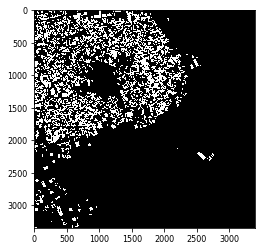

In [25]:
c = 0# class
print masks[im_id][c].sum()
show(masks[im_id][c], cmap='gray')

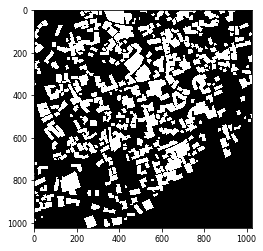

In [26]:
show(y_val[i_val, ..., c], cmap='gray')

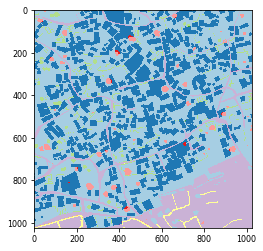

In [18]:
show(((2**np.arange(N_CLASSES))*y_val[i_val, ...]).sum(axis=-1) % 12, cmap='Paired', vmin=0, vmax=11)

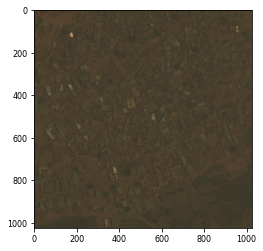

In [22]:
im_val = (X_val[i_val] >> 3).astype(np.uint8)
show(im_val)

In [21]:
print X_val.dtype

int64
